<a href="https://colab.research.google.com/github/CorentinMAG/SRGAN/blob/main/SuperResolutionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, Dense, Layer
from tensorflow.keras.layers import concatenate, Add
from tensorflow.keras.layers import BatchNormalization, Activation, PReLU, LeakyReLU
from tensorflow.keras.layers import Input, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil
import os
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(f' keras version : {tf.keras.__version__}')

# change data format
if True:
  tf.keras.backend.set_image_data_format('channels_last')
else:
  tf.keras.backend.set_image_data_format('channels_first')

print(f' data format : {tf.keras.backend.image_data_format()}')
print(f' tensorflow version : {tf.__version__}')
tf.config.list_physical_devices()

 keras version : 2.4.0
 data format : channels_last
 tensorflow version : 2.4.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
blocks = 16
data_format = tf.keras.backend.image_data_format()
# channel_last (bs, H, W, C)
# channel_first (bs, C, H, W)

# axis used in Parametric ReLU !
# the space dimension
shared_axis = [1,2] if data_format == 'channel_last' else [2, 3]

# axis for Batch Normalization
# the channel dim
axis = -1 if data_format == 'channel_last' else 1

In [4]:
class ResBlock(Layer):

  def __init__(self, axis, shared_axis, **kwargs):
    super(ResBlock, self).__init__(**kwargs)
    self.axis = axis
    self.shared_axis = shared_axis
    self.res_conv = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None, use_bias = False)
    self.batch = BatchNormalization(axis = self.axis)
    self.prelu = PReLU(shared_axes = self.shared_axis)
    self.add = Add()

  def call(self, inputs, training = True):

    x = self.res_conv(inputs)
    x = self.batch(x, training = training)
    x = self.prelu(x)

    x = self.res_conv(x)
    x = self.batch(x, training = training)

    return self.add([x, inputs])

  def get_config(self):

    config = super().get_config().copy()
    config.update({
        'axis': self.axis,
        'shared_axis': self.shared_axis
    })

    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class UpBlock(Layer):

  def __init__(self, shared_axis, **kwargs):
    super(UpBlock, self).__init__(**kwargs)
    self.shared_axis = shared_axis
    self.up_conv = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None, use_bias = False)
    # The Pixel Shuffle transformation reorganize the low-resolution image channels to obtain a bigger image with few channels
    # This can be very useful after a convolutional process, in which the number of filters drastically increase the number of channels, to invert the transformation like a sort of deconvolution function.
    # he training is process is also musch more faster than a simple UpSampling2D layer
    self.pixel_shuffle = Lambda(self.pixelShuffle(block_size = 2))
    self.prelu = PReLU(shared_axes = self.shared_axis)
  
  def call(self, inputs, training):
    x = self.up_conv(inputs)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x
  def hello(w):
    print(f'hello {w}')
  
  def pixelShuffle(self, block_size, data_format = 'NHWC'):
    return lambda x: tf.nn.depth_to_space(x, block_size = block_size, data_format = data_format)

  def get_config(self):

    config = super().get_config().copy()
    config.update({
        'shared_axis': self.shared_axis
    })

    return config
  
  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [48]:
class Generator(Model):

  """
  estimates for a given input LR image its corresponding HR image which is a super resolved image SR.
  SRResNet
  """

  def __init__(self, axis, shared_axis, blocks, **kwargs):
    super(Generator, self).__init__(name = 'generator', **kwargs)

    self.axis = axis
    self.shared_axis = shared_axis
    self.blocks = blocks
    self.conv_0 = Conv2D(filters = 64, kernel_size = (9, 9), strides = (1, 1), padding = 'same', activation = None)
    self.res_conv = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None, use_bias = False)
    self.ResBlock = ResBlock(self.axis, self.shared_axis)
    self.UpBlock = UpBlock(self.shared_axis)
    self.UpBlock2 = UpBlock(self.shared_axis)
    self.prelu = PReLU(shared_axes = self.shared_axis)
    self.batch = BatchNormalization(axis = self.axis)
    self.add = Add()
    self.last_conv = Conv2D(filters = 3, kernel_size = (9, 9), strides = (1, 1), activation = 'tanh', use_bias = False, padding = 'same') # we use tanh because images are normalized to be in range [0, 1] (sigmoid)
                                                                                                                                          # or [-1, 1] (tanh)

  def plot_prediction(self, img):
    if len(img.shape) == 3:
      img = tf.expand_dims(img, axis = 0)
    sr_img = self(img)
    sr_img *= 255 # from [0, 1] to [0, 255]
    sr_img = tf.cast(sr_img, tf.uint8)
    sr_img = tf.squeeze(sr_img)
    plt.imshow(sr_img)

  def call(self, inputs, training = True): # (bs, H, W, 3)
    x = self.conv_0(inputs)  # (bs, H, W, 64)
    x1 = self.prelu(x)    # (bs, H, W, 64)

    x = x1 # skip connection  (bs, H, W, 64)

    for _ in range(self.blocks):
      x = self.ResBlock(x, training) # (bs, H, W, 64)

    x = self.res_conv(x) # (bs, H, W, 64)
    x = self.batch(x, training = training) # (bs, H, W, 64)
    x = self.add([x, x1]) # (bs, H, W, 64)

    x = self.UpBlock(x) # (bs, 2H, 2W, 256)
    x = self.UpBlock2(x) # (bs, 4H, 4W, 256)

    output = self.last_conv(x) # (bs, 4H, 4W, 3)

    return output

In [6]:
class ConvBlock(Layer):

  def __init__(self, filters, kernel_size, strides, axis, **kwargs):
    super(ConvBlock, self).__init__(self, **kwargs)
    self.axis = axis
    self.filters = filters
    self.kernel_size = kernel_size
    self.strides = strides
    self.conv = Conv2D(filters = self.filters, kernel_size = self.kernel_size, strides = self.strides, padding = 'same', activation = None, use_bias = False)
    self.batch = BatchNormalization(axis = self.axis)
    self.leaky = LeakyReLU(alpha = 0.2)

  def call(self, inputs, training = True):
    x = self.conv(inputs)
    x = self.batch(x, training = training)
    x = self.leaky(x)
    return x

  def get_config(self):

    config = super().config().copy()
    config.update({
        'filters': self.filters,
        'kernel_size': self.kernel_size,
        'strides': self.strides,
        'axis': self.axis
    })

    return config

  @classmethod
  def from_config(cld, config):
    return cls(**config)


class Discriminator(Model):

  """
  trained to distinguish super resolved (SR) images and real (HR) images.
  """

  def __init__(self, axis, data_format, **kwargs):
    super(Discriminator, self).__init__(name = 'discriminator', **kwargs)

    self.axis = axis
    self.data_format = data_format
    self.conv_0 = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None, use_bias = False)
    self.leaky = LeakyReLU(alpha = 0.2)
    self.flatten = Flatten(data_format = self.data_format)
    self.dense = Dense(1024, activation = None)
    self.dense_output = Dense(1, activation = 'sigmoid')
    self.block_1 = ConvBlock(64, (3, 3), (2, 2), self.axis)
    self.block_2 = ConvBlock(128, (3, 3), (1, 1), self.axis)
    self.block_3 = ConvBlock(128, (4, 4), (2, 2), self.axis)
    self.block_4 = ConvBlock(256, (3, 3), (1, 1), self.axis)
    self.block_5 = ConvBlock(256, (4, 4), (2, 2), self.axis)
    self.block_6 = ConvBlock(512, (3, 3), (1, 1), self.axis)
    self.block_7 = ConvBlock(512, (4, 4), (2, 2), self.axis)

  def call(self, inputs, training = True): #(bs, H, W, 3)
    x = self.conv_0(inputs) # (bs, H, W, 64)
    x = self.leaky(x) # (bs, H, W, 64)

    x = self.block_1(x, training) # (bs, H/2, W/2, 64)
    x = self.block_2(x, training) # (bs, H/2, W/2, 128)
    x = self.block_3(x, training) # (bs, H/4, W/4, 128)
    x = self.block_4(x, training) # (bs, H/4, W/4, 256)
    x = self.block_5(x, training) # (bs, H/8, W/8, 256)
    x = self.block_6(x, training) # (bs, H/8, W/8, 512)
    x = self.block_7(x, training) # (bs, H/16, W/16, 512)

    x = self.flatten(x) # (bs, (H*W*512)/16)
    x = self.dense(x) # (bs, 1024)
    x = self.leaky(x) # (bs, 1024)
    output = self.dense_output(x) # (bs, 1)
    return output

In [7]:
! wget http://images.cocodataset.org/zips/train2014.zip

--2021-04-04 08:53:44--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.248.236
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.248.236|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  34.3MB/s    in 6m 21s  

2021-04-04 09:00:06 (33.8 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [8]:
!unzip -qq train2014.zip

In [9]:
!rm -rf train2014.zip

In [10]:
def split(folder, test_size = 0.2, random_state = 45):

  """
  create train/test splits
  """

  curr = os.path.join(os.getcwd(), folder)
  images = os.listdir(curr)
  train, test = train_test_split(images, test_size = test_size, random_state = random_state)

  train_folder = os.path.join(curr, 'train')
  test_folder = os.path.join(curr, 'test')

  if not os.path.exists(train_folder):
    os.mkdir(train_folder)

  if not os.path.exists(test_folder):
    os.mkdir(test_folder)

  for image in train:
    src_path = os.path.join(curr, image)
    dst_path = os.path.join(train_folder, image)
    shutil.move(src_path, dst_path)

  for image in test:
    src_path = os.path.join(curr, image)
    dst_path = os.path.join(test_folder, image)
    shutil.move(src_path, dst_path)

In [11]:
split('train2014')

In [12]:
class BatchGenerator(tf.keras.utils.Sequence):

  """
  dataset class
  """

  def __init__(self,folder, batch_size, img_size, downscale_factor, data_format, **kwargs):
    self.batch_size = batch_size
    self.folder = folder
    self.downscale_factor = downscale_factor
    self.img_size = img_size
    self.curr = os.path.join(os.getcwd(), self.folder)
    self.data_format = data_format
    self.__get_batches()

  def __get_batches(self):
    images = os.listdir(self.curr)
    if '.ipynb_checkpoints' in images:
      images.remove('.ipynb_checkpoints')
    batches = [[img for img in images[i: i + self.batch_size]] for i in range(0, len(images), self.batch_size)]
    self.batches = batches

  def __len__(self):
    return len(self.batches)

  def __repr__(self):
    return 'BatchGenerator : image size : ({},{}) downscale factor : {}'.format(self.img_size[0], self.img_size[1], self.downscale_factor)

  def downscale(self, img):

    lr_img = img.resize(
            [self.img_size[0] // self.downscale_factor, self.img_size[1] // self.downscale_factor], 
            Image.BICUBIC)
    return lr_img

  def plot_batch(self, idx):
    batch = self.__getitem__(idx, normalize = False)

    plt.figure(figsize = (20, 4))
    for i, (hr_image, lr_image) in enumerate(zip(batch[0], batch[1])):
      # display HR
      ax = plt.subplot(2, self.batch_size, i + 1)
      plt.imshow(hr_image)
      plt.title("HR image")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display LR
      ax = plt.subplot(2, self.batch_size, i + 1 + self.batch_size)
      plt.imshow(lr_image)
      plt.title("LR image")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    plt.show()
  
  def __getitem__(self, idx, normalize = True):
    batch = self.batches[idx]

    hr_tensor = []
    lr_tensor = []

    for filename in batch:
      path = os.path.join(self.curr, filename)
      img = tf.image.decode_image(tf.io.read_file(path)) # tf.uint8
      img = tf.image.resize_with_crop_or_pad(img, self.img_size[0], self.img_size[1]) # all images should have the same dimensions (H, W, 3)
      img = tf.squeeze(img) # (H, W, 3) or (H, W)

      if len(img.shape) == 2:
        img = tf.stack([img] * 3, axis = 2) # if the image has only 2 dim (grayscale) we convert it to an rgb image # (H, W, 3)

      hr_img = ((2 * tf.cast(img, tf.float32)) / 255.0) - 1.0 if normalize else img  # we scale hr_img between [-1, 1] (H, W, 3)

      if self.data_format == 'channel_first':
        hr_img = tf.transpose(hr_img, perm = [1, 2, 0]) # (3, H, W)
      hr_tensor.append(hr_img)


      lr_img = Image.fromarray(img.numpy()).filter(ImageFilter.GaussianBlur)  # we do this to remove noise from the image (H, W, 3)
      lr_img = self.downscale(lr_img) # (rH, rW, 3)
      lr_img = tf.convert_to_tensor(np.array(lr_img), tf.float32) / 255.0 if normalize else tf.convert_to_tensor(np.array(lr_img)) # we scale lr_img between [0, 1] (H, W, 3)

      if self.data_format == 'channel_first':
        lr_img = tf.transpose(lr_img, perm = [1, 2, 0]) # (3, H, W)
      lr_tensor.append(lr_img)

    return (
        tf.convert_to_tensor(hr_tensor), # (bs, H, W, 3) or (bs, 3, H, W)
        tf.convert_to_tensor(lr_tensor) # (bs, rH, rW, 3) or (bs, 3, H, W)
    )

* convert our images from the RGB color space to the YUV color space ?
* BGR instead of RGB format ?

In [13]:
train_dataset = BatchGenerator('train2014/train', 10, (200, 200), 4, data_format)

In [14]:
val_dataset = BatchGenerator('train2014/test', 10, (200, 200), 4, data_format)

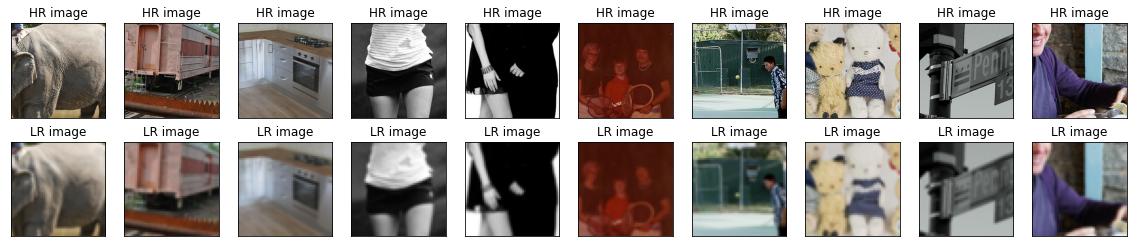

In [15]:
train_dataset.plot_batch(0)

In [49]:
# init optimizer for the training of the generator with the mse loss
init_gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.9)

# optimizers and losses for the training
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

disc_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.9)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.9)

# models
generator = Generator(axis, shared_axis, blocks)
discriminator = Discriminator(axis, data_format)
#vgg = VGG(shape = (200, 200, 3))

In [45]:
vgg = VGG19(include_top = False, input_shape=(200,200,3), weights = 'imagenet')
vgg.trainable = False
vgg19 = Model(inputs = vgg.input, outputs = vgg.get_layer('block2_conv2').output)

In [18]:
def rescale_features_for_vgg(features):
  # scale from [-1, 1] to [0, 255]
  features += 1
  features *= 127.5

  # The images are converted from RGB to BGR, then each color channel is 
  # zero-centered with respect to the ImageNet dataset, without scaling.
  features = tf.keras.applications.vgg19.preprocess_input(features)

  return features

In [19]:
# adversarial loss
def discriminator_loss(ytrue, yfake):
    real_loss = cross_entropy(tf.ones_like(ytrue), ytrue)
    fake_loss = cross_entropy(tf.zeros_like(yfake), yfake)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
# We employed the trained MSE-based SRResNetnetwork as initialization for the generator 
# when training the actual GAN to avoid undesired local optima
@tf.function
def pre_train_step(images):
  hr_images, lr_images = images

  # init learning
  with tf.GradientTape() as gen_tape:
    sr_images = generator(lr_images)

    content_mse_loss = mse(hr_images, sr_images)

  grd_gen = gen_tape.gradient(content_mse_loss, generator.trainable_variables)
  init_gen_optimizer.apply_gradients(zip(grd_gen, generator.trainable_variables))
  return content_mse_loss

In [21]:
@tf.function
def pre_val_step(images):
  hr_images, lr_images = images

  sr_images = generator(lr_images, training = False)
  content_mse_loss = mse(hr_images, sr_images)
  return content_mse_loss

In [22]:
@tf.function
def train_step(images):
  hr_images, lr_images = images

  # adversarial learning
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    sr_images = generator(lr_images)

    fake_out = discriminator(sr_images)
    real_out = discriminator(hr_images)

    sr_features = vgg19(rescale_features_for_vgg(sr_images))
    hr_features = vgg19(rescale_features_for_vgg(hr_images))

    disc_loss = discriminator_loss(real_out, fake_out)
    gen_loss = generator_loss(fake_out)

    content_mse_loss = mse(hr_images, sr_images)
    content_vgg_loss = 0.06 * mse(hr_features, sr_features)

    percept_loss = (content_mse_loss + content_vgg_loss) + (10e-3 * gen_loss)

    gen_grad = gen_tape.gradient(percept_loss, generator.trainable_variables)
    disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))

    return disc_loss, gen_loss, content_mse_loss, content_vgg_loss, percept_loss

In [23]:
@tf.function
def val_step(images):
  hr_images, lr_images = images

  sr_images = generator(lr_images, training = False)

  fake_out = discriminator(sr_images, training = False)
  real_out = discriminator(hr_images, training = False)

  sr_features = vgg19(rescale_features_for_vgg(sr_images))
  hr_features = vgg19(rescale_features_for_vgg(hr_images))

  disc_loss = discriminator_loss(real_out, fake_out)
  gen_loss = generator_loss(fake_out)

  content_mse_loss = mse(hr_images, sr_images)
  content_vgg_loss = 0.06 * mse(hr_features, sr_features)

  percept_loss = (content_mse_loss + content_vgg_loss) + (10e-3 * gen_loss)
  return disc_loss, gen_loss, content_mse_loss, content_vgg_loss, percept_loss

In [24]:
def pre_train(train_dataset, val_dataset, epochs):
  best_epoch = -1
  best_loss = 1e6
  threshold = 5
  if os.path.exists('drive/MyDrive/CV/SRGAN/init_generator'):
    print('loading weights...')
    generator.load_weights('drive/MyDrive/CV/SRGAN/init_generator/generator_weights')
    print('Done !')
  for epoch in range(epochs):

    for batch in tqdm(iterable = train_dataset, total = len(train_dataset)):

      tr_loss = pre_train_step(batch)
    
    for batch in val_dataset:

      vl_loss = pre_val_step(batch)

    template = '''
    Epoch : {}, train loss : {:0.5f} | val loss : {:0.5f}'''
    print(template.format(epoch + 1, tr_loss, vl_loss))

    if vl_loss < best_loss:
      best_epoch = epoch
      best_loss = vl_loss
      print('\nSaving weights...')
      generator.save_weights('drive/MyDrive/CV/SRGAN/init_generator/generator_weights')
      print('\nDone !')
    if epoch > threshold + best_epoch:
      print(f'\n no improvment of the valid loss since {threshold} epochs, terminating training... ! best epoch : {best_epoch} with best loss : {best_loss}')
      break

In [25]:
def train(train_dataset, val_dataset, epochs):
  best_epoch = -1
  best_loss = 2643.78638
  threshold = 5
  if os.path.exists('drive/MyDrive/CV/SRGAN/generator'):
    # resume training
    generator.load_weights('drive/MyDrive/CV/SRGAN/generator/generator_weights')

  elif os.path.exists('drive/MyDrive/CV/SRGAN/init_generator'):
    # the real training has not started yet but the pre-training is over
    generator.load_weights('drive/MyDrive/CV/SRGAN/init_generator/generator_weights')
  else:
    raise FileNotFoundError('You must pre-train the generator !')
  for epoch in range(epochs):

    for batch in tqdm(iterable = train_dataset, total = len(train_dataset)):

      tr_disc_loss, tr_gen_loss, tr_content_mse_loss, tr_content_vgg_loss, tr_percept_loss = train_step(batch)

    for batch in val_dataset:
      vl_disc_loss, vl_gen_loss, vl_content_mse_loss, vl_content_vgg_loss, vl_percept_loss = val_step(batch)

    template = '''
    Epoch : {}, 
    tr_discriminator_loss : {:0.5f} | tr_generator_loss : {:0.5f} | tr_content_mse_loss : {:0.5f} | tr_content_vgg_loss : {:0.5f} | tr_percept_loss : {:0.5f}
    val_discriminator_loss : {:0.5f} | val_generator_loss : {:0.5f} | val_content_mse_loss : {:0.5f} | val_content_vgg_loss : {:0.5f} | val_percept_loss : {:0.5f}'''
    print(template.format(epoch + 1, tr_disc_loss, tr_gen_loss, tr_content_mse_loss, 
                          tr_content_vgg_loss, tr_percept_loss, vl_disc_loss, 
                          vl_gen_loss, vl_content_mse_loss, vl_content_vgg_loss, vl_percept_loss))
    
    if vl_percept_loss < best_loss:
      best_epoch = epoch
      best_loss = vl_percept_loss
      print('\nSaving weights...')
      generator.save_weights('drive/MyDrive/CV/SRGAN/generator/generator_weights')
      print('\nDone !')
    if epoch > threshold + best_epoch:
      print(f'\n no improvment of the valid loss since {threshold} epochs, terminating training... ! best epoch : {best_epoch} with best loss : {best_loss}')
      break

In [ ]:
EPOCHS = 50
pre_train(train_dataset, val_dataset, EPOCHS)

loading weights...


100%|██████████| 6623/6623 [28:27<00:00,  3.88it/s]


Done !

    Epoch : 1, train loss : 0.02260 | val loss : 0.10267

Saving weights...


  0%|          | 1/6623 [00:00<13:40,  8.07it/s]


Done !


  0%|          | 0/6623 [00:00<?, ?it/s]


    Epoch : 2, train loss : 0.02258 | val loss : 0.09990

Saving weights...

Done !


  0%|          | 1/6623 [00:00<14:01,  7.87it/s]


    Epoch : 3, train loss : 0.02255 | val loss : 0.09893

Saving weights...

Done !


  0%|          | 1/6623 [00:00<13:10,  8.38it/s]


    Epoch : 4, train loss : 0.02254 | val loss : 0.09941


  0%|          | 1/6623 [00:00<13:25,  8.22it/s]


    Epoch : 5, train loss : 0.02250 | val loss : 0.10081


  0%|          | 1/6623 [00:00<13:12,  8.35it/s]


    Epoch : 6, train loss : 0.02246 | val loss : 0.10273


  0%|          | 1/6623 [00:00<14:03,  7.85it/s]


    Epoch : 7, train loss : 0.02243 | val loss : 0.10589


  0%|          | 1/6623 [00:00<13:34,  8.13it/s]


    Epoch : 8, train loss : 0.02240 | val loss : 0.10781


100%|██████████| 6623/6623 [27:39<00:00,  3.99it/s]



    Epoch : 9, train loss : 0.02239 | val loss : 0.11047

 no improvment of the valid loss since 5 epochs, terminating training... ! best epoch : 2 with best loss : 0.09893372654914856


In [26]:
EPOCHS = 50
train(train_dataset, val_dataset, EPOCHS)

100%|██████████| 6623/6623 [39:14<00:00,  2.81it/s]



    Epoch : 1, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 201.20488 | tr_content_mse_loss : 0.02322 | tr_content_vgg_loss : 1211.54175 | tr_percept_loss : 1213.57703
    val_discriminator_loss : 17.97746 | val_generator_loss : 0.00005 | val_content_mse_loss : 0.05221 | val_content_vgg_loss : 2181.26562 | val_percept_loss : 2181.31787

Saving weights...


  0%|          | 0/6623 [00:00<?, ?it/s]


Done !


  0%|          | 0/6623 [00:00<?, ?it/s]


    Epoch : 2, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 182.22200 | tr_content_mse_loss : 0.02388 | tr_content_vgg_loss : 1209.89392 | tr_percept_loss : 1211.74011
    val_discriminator_loss : 22.56552 | val_generator_loss : 0.00000 | val_content_mse_loss : 0.05088 | val_content_vgg_loss : 2175.98975 | val_percept_loss : 2176.04053

Saving weights...

Done !


  0%|          | 0/6623 [00:00<?, ?it/s]


    Epoch : 3, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 327.73117 | tr_content_mse_loss : 0.02384 | tr_content_vgg_loss : 1207.63318 | tr_percept_loss : 1210.93433
    val_discriminator_loss : 25.79669 | val_generator_loss : 15.00132 | val_content_mse_loss : 0.04995 | val_content_vgg_loss : 2173.25391 | val_percept_loss : 2173.45386

Saving weights...

Done !


  0%|          | 0/6623 [00:00<?, ?it/s]


    Epoch : 4, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 960.60913 | tr_content_mse_loss : 0.02435 | tr_content_vgg_loss : 1208.05603 | tr_percept_loss : 1217.68640
    val_discriminator_loss : 104.12291 | val_generator_loss : 117.89007 | val_content_mse_loss : 0.04880 | val_content_vgg_loss : 2166.94360 | val_percept_loss : 2168.17139

Saving weights...

Done !


  0%|          | 1/6623 [00:00<21:15,  5.19it/s]


    Epoch : 5, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 1139.45349 | tr_content_mse_loss : 0.02402 | tr_content_vgg_loss : 1206.96313 | tr_percept_loss : 1218.38171
    val_discriminator_loss : 251.31236 | val_generator_loss : 355.51910 | val_content_mse_loss : 0.04810 | val_content_vgg_loss : 2166.64160 | val_percept_loss : 2170.24487


  0%|          | 0/6623 [00:00<?, ?it/s]


    Epoch : 6, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 1172.97595 | tr_content_mse_loss : 0.02440 | tr_content_vgg_loss : 1206.90613 | tr_percept_loss : 1218.66028
    val_discriminator_loss : 157.21280 | val_generator_loss : 187.96097 | val_content_mse_loss : 0.04679 | val_content_vgg_loss : 2155.95508 | val_percept_loss : 2157.88159

Saving weights...

Done !


  0%|          | 1/6623 [00:00<21:06,  5.23it/s]


    Epoch : 7, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 1388.73730 | tr_content_mse_loss : 0.02459 | tr_content_vgg_loss : 1206.95776 | tr_percept_loss : 1220.86963
    val_discriminator_loss : 150.92383 | val_generator_loss : 244.25742 | val_content_mse_loss : 0.04705 | val_content_vgg_loss : 2161.96265 | val_percept_loss : 2164.45239


  0%|          | 1/6623 [00:00<21:25,  5.15it/s]


    Epoch : 8, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 1564.29041 | tr_content_mse_loss : 0.02436 | tr_content_vgg_loss : 1206.00024 | tr_percept_loss : 1221.66760
    val_discriminator_loss : 487.41714 | val_generator_loss : 456.84842 | val_content_mse_loss : 0.04650 | val_content_vgg_loss : 2162.15820 | val_percept_loss : 2166.77319


  0%|          | 1/6623 [00:00<21:22,  5.16it/s]


    Epoch : 9, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 1458.01526 | tr_content_mse_loss : 0.02417 | tr_content_vgg_loss : 1205.24512 | tr_percept_loss : 1219.84949
    val_discriminator_loss : 113.82619 | val_generator_loss : 220.88232 | val_content_mse_loss : 0.04742 | val_content_vgg_loss : 2178.21362 | val_percept_loss : 2180.46973


  0%|          | 1/6623 [00:00<21:21,  5.17it/s]


    Epoch : 10, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 1438.39648 | tr_content_mse_loss : 0.02514 | tr_content_vgg_loss : 1205.63635 | tr_percept_loss : 1220.04541
    val_discriminator_loss : 164.70566 | val_generator_loss : 185.06253 | val_content_mse_loss : 0.05037 | val_content_vgg_loss : 2192.47437 | val_percept_loss : 2194.37524


  0%|          | 1/6623 [00:00<21:31,  5.13it/s]


    Epoch : 11, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 1424.04041 | tr_content_mse_loss : 0.02475 | tr_content_vgg_loss : 1203.63184 | tr_percept_loss : 1217.89697
    val_discriminator_loss : 352.61148 | val_generator_loss : 404.85175 | val_content_mse_loss : 0.04640 | val_content_vgg_loss : 2173.20483 | val_percept_loss : 2177.29980


100%|██████████| 6623/6623 [38:10<00:00,  2.89it/s]



    Epoch : 12, 
    tr_discriminator_loss : 0.00000 | tr_generator_loss : 1494.19080 | tr_content_mse_loss : 0.02433 | tr_content_vgg_loss : 1202.94250 | tr_percept_loss : 1217.90869
    val_discriminator_loss : 438.18381 | val_generator_loss : 466.75323 | val_content_mse_loss : 0.04562 | val_content_vgg_loss : 2171.03516 | val_percept_loss : 2175.74829

 no improvment of the valid loss since 5 epochs, terminating training... ! best epoch : 5 with best loss : 2157.881591796875


In [50]:
generator.load_weights('drive/MyDrive/CV/SRGAN/generator/generator_weights')

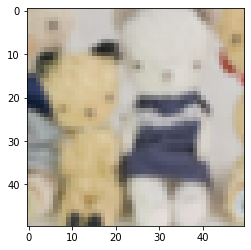

In [62]:
plt.imshow(train_dataset[0][1][7])

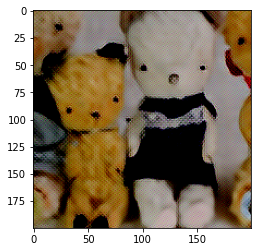

In [63]:
generator.plot_prediction(train_dataset[0][1][7])

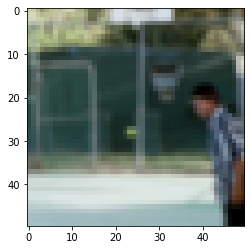

In [64]:
plt.imshow(train_dataset[0][1][6])

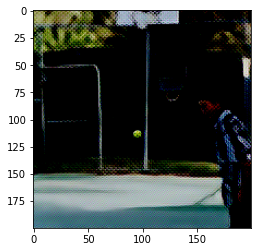

In [65]:
generator.plot_prediction(train_dataset[0][1][6])